# Introduction

This is my first attempt at a Kaggle competition or a data science project in general. Among the available introductory competitions, Titanic: Machine Learning from Disaster was the one I found most exciting. The objective of this competition is to determine whether a passenger will survive the shipwreck based on their recorded profile. With this notebook I achieved an **accuracy of 0.81339** on the test dataset, scoring in the **top 3%** of the public leaderboard.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Read in training and test data

The training and test datasets are combined so all transformations and feature engineering can be applied to both simultaneously.

In [2]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

test_data_id = test_data["PassengerId"]
len_train_data = len(train_data)

combine_data = pd.concat([train_data, test_data], ignore_index=True)
combine_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Filling in missing data

5 columns have missing values.

In [3]:
cols_null_data = [col for col in combine_data.columns if combine_data[col].isnull().any()]
combine_data[cols_null_data].isnull().sum()

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

#### Missing data: Embarked

Since only 2 values are missing from Embarked, these can be filled in with the most common value 'S'.

In [4]:
combine_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [5]:
combine_data['Embarked'].fillna('S', inplace=True)

#### Missing data: Fare

Generating a correlation matrix to analyze the relationships between numeric features.

In [6]:
combine_data[combine_data.columns].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.028814,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.178740,0.160238,0.221539,1.000000


Fare is the most correlated to Pclass, SibSp and Parch. The 1 missing Fare value can be estimated by calculating the median Fare of passengers that share the same Pclass, SibSp and Parch.

In [7]:
combine_data[combine_data['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [8]:
fare_estimate = combine_data[(combine_data['Pclass'] == 3) & (combine_data['SibSp'] == 0) & (combine_data['Parch'] == 0)]['Fare'].median()
combine_data['Fare'].fillna(fare_estimate, inplace=True)

#### Missing data: Age

Age is the most correlated to Pclass and Sex. The missing Age values can be estimated by calculating the median Age of passengers that share the same Pclass and Sex. Using other features to better estimate the Age values was ineffective as it resulted in numerous empty subsets and therefore having to be filled with the overall median Age.

In [9]:
age_nan_idx = list(combine_data[combine_data['Age'].isna()].index)

for i in age_nan_idx:
    closest_data = combine_data.loc[(
        (combine_data['Pclass'] == combine_data.iloc[i]['Pclass']) &
        (combine_data['Sex'] == combine_data.iloc[i]['Sex'])
    ), 'Age']
    
    closest_data = closest_data.dropna()
    
    if closest_data.shape[0] > 0:
        combine_data.loc[combine_data.index == i, 'Age'] = closest_data.median()
    else:
        combine_data.loc[combine_data.index == i, 'Age'] = combine_data['Age'].median()

Only 2 columns remain with missing values. 
* Survived is the target variable. The missing values are expected.
* Cabin also has missing values. Unlike the other features, missing values here convey important information. It means the passenger did not have a cabin. This will be addressed in the Feature Engineering section.

In [10]:
cols_null_data = [col for col in combine_data.columns if combine_data[col].isnull().any()]
combine_data[cols_null_data].isnull().sum()

Survived     418
Cabin       1014
dtype: int64

# Feature Engineering

#### Feature engineering: Fare

Fare is split into 13 bins. The value 13 is chosen experimentally. The reasoning for binning Fare is to help the model in recognizing groups of Fare values that have a better chance of survival. It also helps get rid of outliers.

In [11]:
combine_data['Fare'] = pd.qcut(combine_data['Fare'], 13)

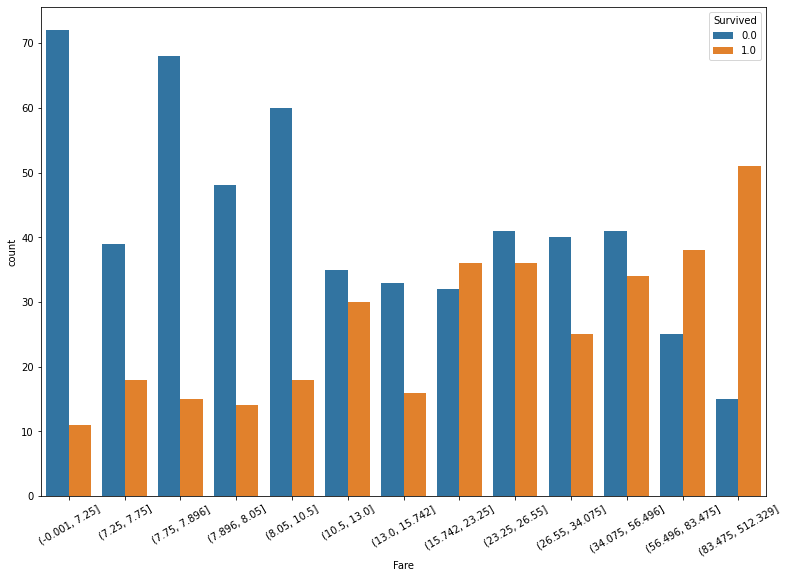

In [12]:
plt.figure(figsize=(13, 9))
g = sns.countplot(x='Fare', hue='Survived', data=combine_data)
g = g.set_xticklabels(g.get_xticklabels(), rotation=30)

#### Feature engineering: Age

Age is split into 10 bins. The value 10 is chosen experimentally. The reasoning for binning Age is to help the model in recognizing age groups that have a better chance of survival. It also helps get rid of outliers.

In [13]:
combine_data['Age'] = pd.qcut(combine_data['Age'], 10)

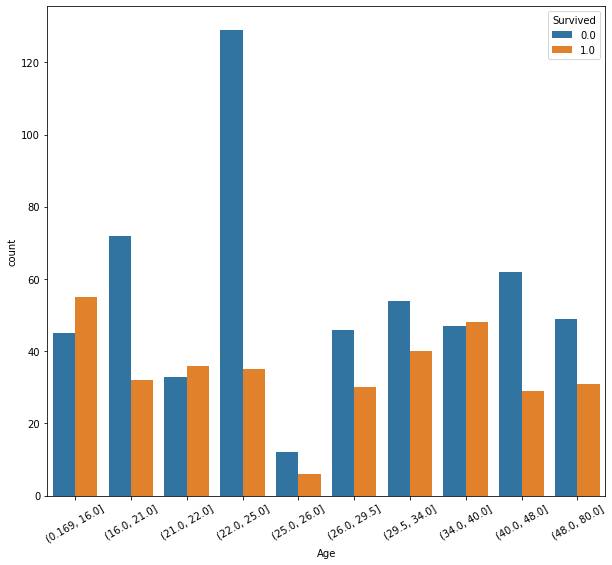

In [14]:
plt.figure(figsize=(10, 9))
g = sns.countplot(x='Age', hue='Survived', data=combine_data)
g = g.set_xticklabels(g.get_xticklabels(), rotation=30)

#### Feature engineering: Ticket

Passengers with the same ticket number are likely to be travelling together. They could be direct family, relatives or friends. As seen in the graph below, passengers with a low Ticket_Count (alone) or ones with a higher Ticket_Count (large families/groups) tend to have a lower chance of survival.

In [15]:
combine_data['Ticket_Count'] = combine_data.groupby('Ticket')['Ticket'].transform('count')

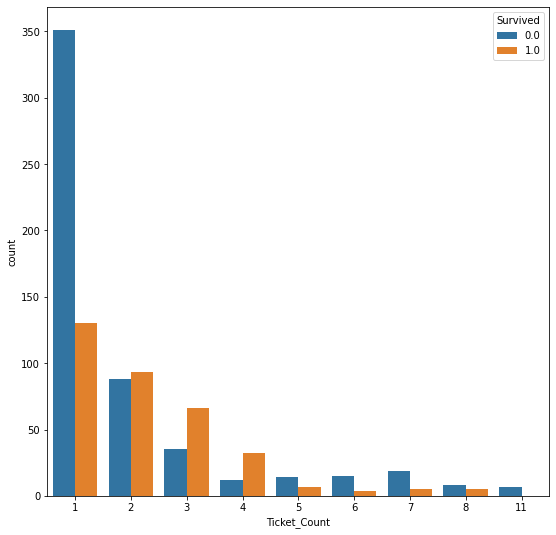

In [16]:
plt.figure(figsize=(9, 9))
g = sns.countplot(x='Ticket_Count', hue='Survived', data=combine_data)
sns.move_legend(g, "upper right")

#### Feature engineering: Cabin

Creating a new column that captures the cabin level (A, B, C, etc.). If Cabin value is missing then it is assumed that the passenger did not have a cabin and 'X' is used as a placeholder.

In [17]:
cabin_lvl = []
for i in combine_data['Cabin']:
    if not pd.isnull(i):
        first_cabin = i.split()[0]
        cabin_lvl.append(first_cabin[0])
    else:
        cabin_lvl.append('X')

combine_data['Cabin_Level'] = cabin_lvl

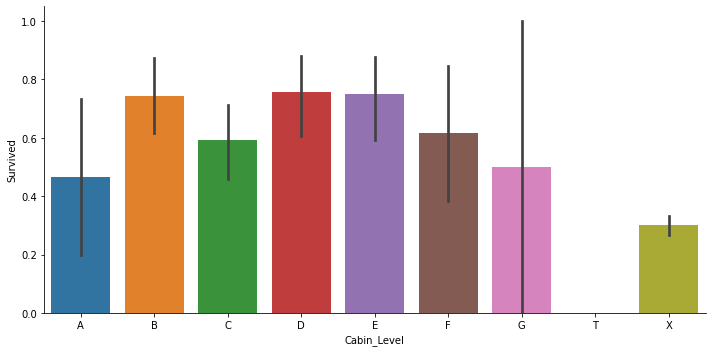

In [18]:
g = sns.catplot(x="Cabin_Level",y="Survived",data=combine_data,kind="bar", order=sorted(combine_data['Cabin_Level'].unique()), aspect=2)

There is only 1 passenger with the Cabin_Level 'T'. It is futile to have a separate category for this particular passenger. Since this passenger is Pclass 1 and all passengers in Cabin_Level 'A' are Pclass 1, lets change their Cabin_Level to 'A'.

In [19]:
combine_data[combine_data['Cabin'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Count,Cabin_Level
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,"(40.0, 48.0]",0,0,113784,"(34.075, 56.496]",T,S,1,T


In [20]:
combine_data[combine_data['Cabin_Level'] == 'A']['Pclass'].value_counts()

1    22
Name: Pclass, dtype: int64

Adjacent Cabin_Levels with similar survival rates are grouped together.

In [21]:
cabin_map = {"A":"ABC", "B":"ABC", "C":"ABC", "D":"DE", "E":"DE", "F":"FG", "G":"FG", "T":"ABC", "X":"X"}
combine_data["Cabin_Level"] = combine_data["Cabin_Level"].map(cabin_map)

#### Feature engineering: Name

The passenger's Title is extracted from their Name and similar ones are grouped together. The Title 'Mrs' also indicates if they are married or not.

In [22]:
combine_data['Title'] = pd.Series([i.split(',')[1].split('.')[0].strip() for i in combine_data['Name']])

combine_data['Is_Married'] = 0
combine_data.loc[combine_data['Title'] == 'Mrs', 'Is_Married'] = 1

combine_data['Title'] = combine_data['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
combine_data['Title'] = combine_data['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Professional')

combine_data['Title'].value_counts()

Mr                 757
Miss/Mrs/Ms        465
Master              61
Dr/Professional     26
Name: Title, dtype: int64

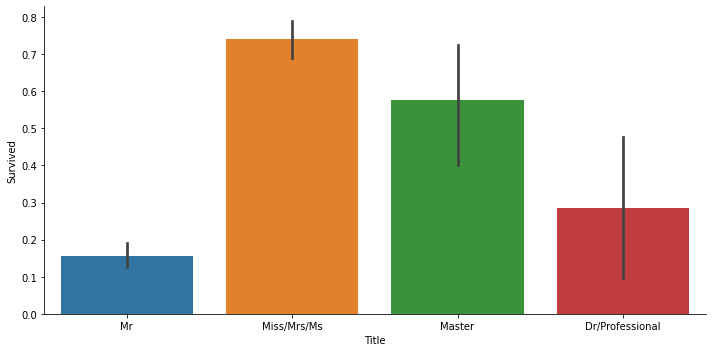

In [23]:
plot = sns.catplot(x="Title",y="Survived",data=combine_data,kind="bar", aspect=2)

The passenger's Family name is extracted from their Name.

In [24]:
combine_data["Family"] = pd.Series([i.split(',')[0].strip() for i in combine_data['Name']])

#### Feature engineering: SibSp & Parch

The number of family members for each passenger is calculated by adding SibSp, Parch and 1 (themselves).

In [25]:
combine_data['Family_Count'] = combine_data['SibSp'] + combine_data['Parch'] + 1

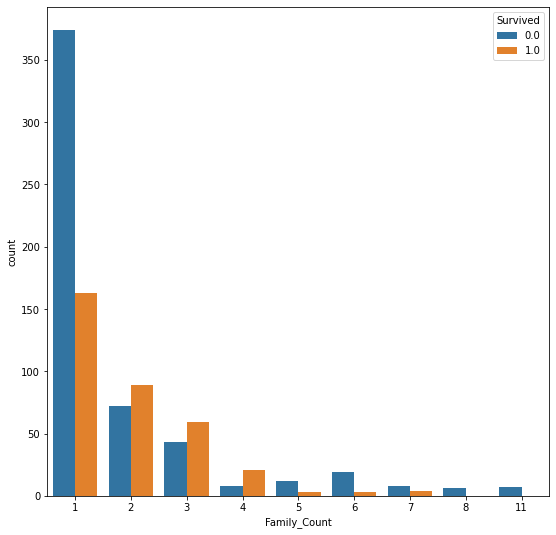

In [26]:
plt.figure(figsize=(9, 9))
g = sns.countplot(x='Family_Count', hue='Survived', data=combine_data)
sns.move_legend(g, "upper right")

Adjacent Family_Counts with similar survival rates are grouped together.

In [27]:
family_count_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
combine_data['Family_Size'] = combine_data['Family_Count'].map(family_count_map)

#### Feature engineering: Survival Rate

Whether a passenger survives or not must be correlated to what happened to the group they are with (family & friends). The Survival_Rate of each passenger is calculated from the fate of other passengers sharing the same Family name or ticket number (average of both). For passengers that are alone or have no family/friends with known fates, the overall survival rate of the training dataset is used. This is indicated by the Survival_Rate_Found feature.

In [28]:
train_data_tmp = combine_data.loc[:len_train_data-1]
test_data_tmp = combine_data.loc[len_train_data:]
mean_survival_rate = train_data_tmp['Survived'].mean()

# Family
combine_data['fam_surv_rt'] = mean_survival_rate
combine_data['fam_surv_rt_found'] = 0

train_data_tmp = train_data_tmp.copy() # group transform gives SettingWithCopyWarning if this is not done
train_data_tmp['fam_cnt_med'] = train_data_tmp.groupby('Family')['Family_Count'].transform('median')
train_family_count_gthan_1 = train_data_tmp.loc[train_data_tmp['fam_cnt_med'] > 1, 'Family'].unique()

train_test_common_family = [x for x in train_data_tmp['Family'].unique() if x in test_data_tmp['Family'].unique()]

for i in range(len(combine_data)):
    if combine_data.loc[combine_data.index[i],'Family'] in train_family_count_gthan_1 and combine_data.loc[combine_data.index[i],'Family'] in train_test_common_family:
        combine_data.loc[combine_data.index[i],'fam_surv_rt'] = train_data_tmp.loc[train_data_tmp['Family'] == combine_data.loc[combine_data.index[i],'Family'], 'Survived'].median()
        combine_data.loc[combine_data.index[i],'fam_surv_rt_found'] = 1
        
# Ticket
combine_data['tkt_surv_rt'] = mean_survival_rate
combine_data['tkt_surv_rt_found'] = 0

train_data_tmp = train_data_tmp.copy() # group transform gives SettingWithCopyWarning if this is not done
train_data_tmp['tkt_cnt_med'] = train_data_tmp.groupby('Ticket')['Ticket_Count'].transform('median')
train_ticket_count_gthan_1 = train_data_tmp.loc[train_data_tmp['tkt_cnt_med'] > 1, 'Ticket'].unique()

train_test_common_ticket = [x for x in train_data_tmp['Ticket'].unique() if x in test_data_tmp['Ticket'].unique()]

for i in range(len(combine_data)):
    if combine_data.loc[combine_data.index[i],'Ticket'] in train_ticket_count_gthan_1 and combine_data.loc[combine_data.index[i],'Ticket'] in train_test_common_ticket:
        combine_data.loc[combine_data.index[i],'tkt_surv_rt'] = train_data_tmp.loc[train_data_tmp['Ticket'] == combine_data.loc[combine_data.index[i],'Ticket'], 'Survived'].median()
        combine_data.loc[combine_data.index[i],'tkt_surv_rt_found'] = 1

In [29]:
combine_data['Survival_Rate'] = combine_data[['fam_surv_rt','tkt_surv_rt']].mean(axis=1)
combine_data['Survival_Rate_Found'] = combine_data[['fam_surv_rt_found','tkt_surv_rt_found']].mean(axis=1)

# Encoding & making final modifications to dataset

In [30]:
print(combine_data.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Ticket_Count', 'Cabin_Level', 'Title', 'Is_Married', 'Family', 'Family_Count', 'Family_Size', 'fam_surv_rt', 'fam_surv_rt_found', 'tkt_surv_rt', 'tkt_surv_rt_found', 'Survival_Rate', 'Survival_Rate_Found']


Categorical features with non-numeric values are label encoded.

In [31]:
label_encode_features = ['Sex', 'Age', 'Fare', 'Embarked', 'Cabin_Level', 'Title', 'Family_Size']

for feature in label_encode_features:        
    combine_data[feature] = LabelEncoder().fit_transform(combine_data[feature])

Nominal features are one-hot encoded.

In [32]:
OH_encoded_features = ['Pclass', 'Sex', 'Cabin_Level', 'Embarked', 'Title', 'Family_Size']

for feature in OH_encoded_features:
    OH_result = OneHotEncoder().fit_transform(combine_data[feature].values.reshape(-1, 1)).toarray()
    OH_result = pd.DataFrame(OH_result, columns=['{}_{}'.format(feature, n+1) for n in range(combine_data[feature].nunique())])
    OH_result.index = combine_data.index
    combine_data = pd.concat([combine_data, OH_result], axis=1)

Columns that are not needed are dropped.

In [33]:
cols_to_drop = ['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Cabin_Level', 'Title', 
                'Family', 'Family_Count', 'Family_Size', 'fam_surv_rt', 'fam_surv_rt_found', 'tkt_surv_rt', 'tkt_surv_rt_found']

combine_data.drop(columns=cols_to_drop, inplace=True)

In [34]:
print(combine_data.columns.tolist())

['Survived', 'Age', 'Fare', 'Ticket_Count', 'Is_Married', 'Survival_Rate', 'Survival_Rate_Found', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Sex_2', 'Cabin_Level_1', 'Cabin_Level_2', 'Cabin_Level_3', 'Cabin_Level_4', 'Embarked_1', 'Embarked_2', 'Embarked_3', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4']


In [35]:
combine_data.head()

,Survived,Age,Fare,Ticket_Count,Is_Married,Survival_Rate,Survival_Rate_Found,Pclass_1,Pclass_2,Pclass_3,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4
0,0.0,2,0,1,0,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,7,11,2,1,1.000000,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,4,3,1,0,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,7,10,2,1,0.383838,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,7,3,1,0,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


The training + test combined dataset is split into their original parts. A StandardScaler is used to scale all features evenly.

In [36]:
train_data = combine_data.loc[:len_train_data-1]
test_data = combine_data.loc[len_train_data:]

y_train = train_data['Survived']
X_train = StandardScaler().fit_transform(train_data.drop(columns=['Survived']))
X_test = StandardScaler().fit_transform(test_data.drop(columns=['Survived']))

print('y_train shape: {}'.format(y_train.shape))
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

y_train shape: (891,)
X_train shape: (891, 26)
X_test shape: (418, 26)


# Modeling

Defined a function to calculate and return an average cross validation score on a stratified k-fold with 5 splits using accuracy as the scoring metric (similar to how the public score is calculated).

In [37]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def get_cv_score(model, X, y, cv=kfold, scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores.mean()

Used a Random Forest Classifier (RFC) with default parameters to get a preliminary score. 

In [38]:
model = RandomForestClassifier(random_state=0)

print(get_cv_score(model, X_train, y_train))

0.8271294959512898


Achieved a score of ~0.827. Not bad. The hyperparameters can be tuned to improve the score. Details are in the hidden cell. Note that this step takes a very long time to run.

In [39]:
# Hyperparameter tuning.
# Leave this commented out. Takes a very long time to run.

# rfc_params = {
#                 'n_estimators': [50,200,600,1100],
#                 'criterion': ['gini', 'entropy', 'log_loss'],
#                 'max_depth': [3,4,5,6,7],
#                 'min_samples_split': [2,4,8,16,32],
#                 'min_samples_leaf': [1,2,3,4,5],
#                 'max_features': ['auto', 'sqrt', 'log2', None]
#              }

# gridSearch = GridSearchCV(model, 
#                           param_grid=rfc_params,
#                           cv=kfold,
#                           scoring=scoring_metric,
#                           refit=True,
#                           n_jobs=-1)

# gridSearch.fit(X_train, y_train)
# print("Best params: ",gridSearch.best_params_)
# print("Best score: ",gridSearch.best_score_)

After tuning the hyperparameters, the mean cross validation score achieved is ~0.844.

In [40]:
RFC_model = RandomForestClassifier(random_state=0,
                                   n_estimators=1100,
                                   max_depth=5,
                                   min_samples_split=4,
                                   min_samples_leaf=5)

print(get_cv_score(RFC_model, X_train, y_train))
RFC_model.fit(X_train,y_train)

0.8439771514656957


RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=1100, random_state=0)

# Submission

The tuned RFC model is used to make predictions on the test dataset.

In [41]:
test_predictions = RFC_model.predict(X_test)
test_predictions = [int(x) for x in test_predictions]
test_predictions[:5]

[0, 1, 0, 0, 1]

The output CSV is generated for submission.

In [42]:
output = pd.DataFrame({'PassengerId': test_data_id, 'Survived': test_predictions})
output.to_csv('submission.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!
